# Breast Cancer Histopathology Image Classification Model

### Install dependencies

In [ ]:
!pip install tensorflow-hub

In [2]:
!pip install tensorflow-addons

ERROR: Could not find a version that satisfies the requirement tensorflow-addons (from versions: none)
ERROR: No matching distribution found for tensorflow-addons


In [ ]:
!pip install tf-keras

In [10]:
import os
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.models import Model
# import tensorflow_addons as tfa

from sklearn.metrics import *
# import scikitplot as skplt

from functools import partial
# import albumentations as A
import matplotlib.pyplot as plt
import seaborn as sns

AUTOTUNE = tf.data.experimental.AUTOTUNE
data = pd.read_csv('../data/raw/archive/Folds.csv')
img_dir = '../data/raw/archive/BreaKHis_v1/'
class_names = ['benign', 'malignant']

### Load Data

In [13]:
data = data.rename(columns={'filename':'path'})
data['label'] = data.path.apply(lambda x: x.split('/')[3])
data['label_int'] = data.label.apply(lambda x: class_names.index(x))
data['filename'] = data.path.apply(lambda x: x.split('/')[-1])
data.head(3)

,fold,mag,grp,path,label,label_int,filename
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,0,SOB_B_A-14-22549AB-100-001.png
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,0,SOB_B_A-14-22549AB-100-002.png
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,0,SOB_B_A-14-22549AB-100-003.png


Count of Benign    :  12400
Count of Malignant :  27145


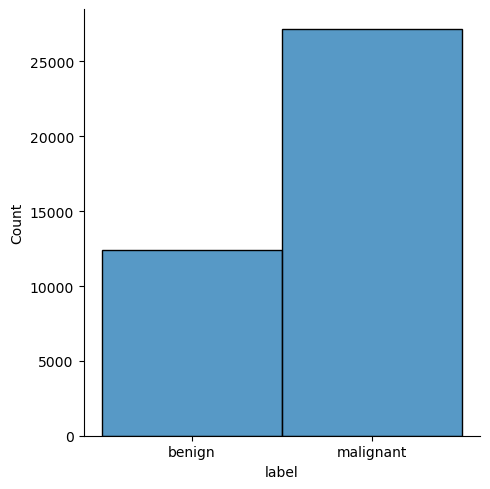

In [15]:
ax = sns.displot(data=data, x='label')
print('Count of Benign    : ', data[data.label == 'benign'].label.count())
print('Count of Malignant : ', data[data.label == 'malignant'].label.count())

### Prepare the data 

Training set
label
malignant    21486
benign        9670
Name: count, dtype: int64

Validation set
label
malignant    5359
benign       2430
Name: count, dtype: int64

Test set
label
benign       300
malignant    300
Name: count, dtype: int64


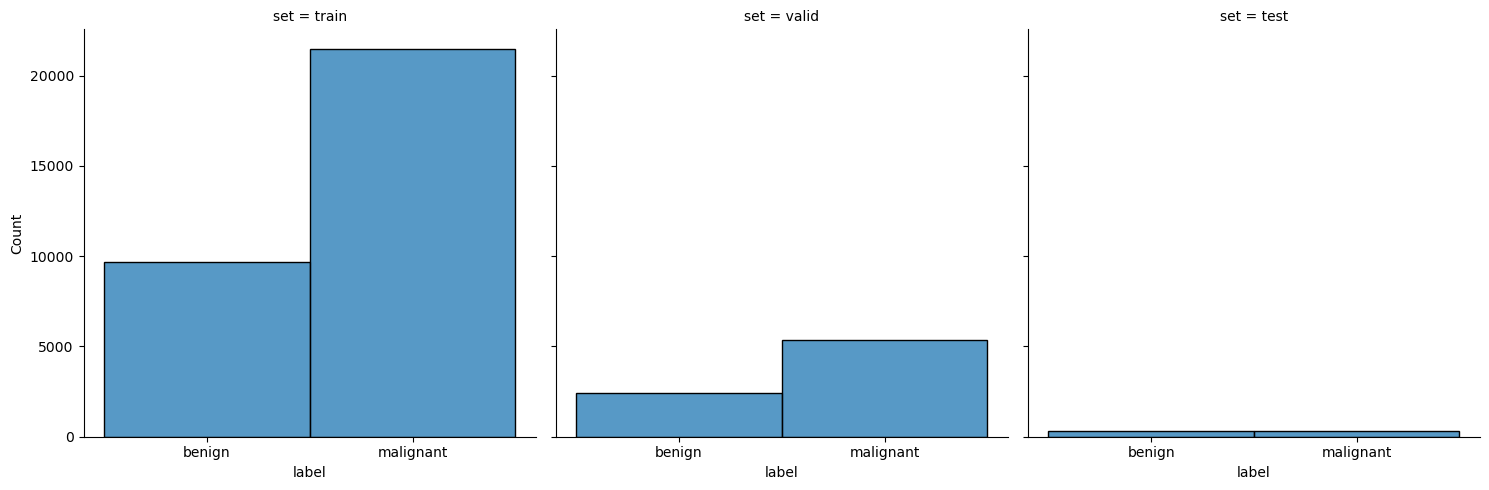

In [17]:
test_df = data.groupby('label').sample(n=300)
train_df = data.drop(test_df.index).reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# split training and validation set
valid_df = train_df.sample(frac=0.2)
train_df = train_df.drop(valid_df.index).reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

test_df['set'] = 'test'
train_df['set'] = 'train'
valid_df['set'] = 'valid'
data_new = pd.concat([train_df,valid_df, test_df])

ax = sns.displot(data=data_new, x='label', col='set')

print('Training set')
print(train_df.label.value_counts())

print('\nValidation set')
print(valid_df.label.value_counts())

print('\nTest set')
print(test_df.label.value_counts())

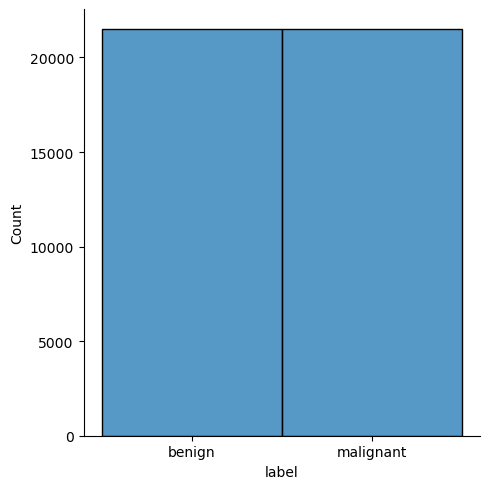

In [19]:
max_count = np.max(train_df.label.value_counts())
min_count = np.min(train_df.label.value_counts())
train_df = train_df.groupby('label').sample(n=max_count, replace=True)
train_df = train_df.reset_index(drop=True)
train_df.label.value_counts()

ax = sns.displot(data=train_df, x='label')

### Base model

In [23]:
model_handle_map = {
    'efficientnetv2-b0': 'https://tfhub.dev/google/imagenet/efficientnetv2-b0/feature_vector/2',
    # Add other models as needed
}

model_image_size_map = {
    'efficientnetv2-b0': 224,
    # Add other models as needed
}

model_name = 'efficientnetv2-b0'
model_handle = model_handle_map.get(model_name)
IMAGE_SIZE = model_image_size_map.get(model_name, 224)
BATCH_SIZE = 64
EPOCHS = 12
SAMPLE_SIZE = len(train_df)

print(f"Selected model: {model_name} : {model_handle}")
print(f"Input size {IMAGE_SIZE}")

Selected model: efficientnetv2-b0 : https://tfhub.dev/google/imagenet/efficientnetv2-b0/feature_vector/2
Input size 224


### Training and validation Data

In [27]:
def parse_image(img_path, label):
    """Function to parse and load images with their labels"""
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img, label

def resize_rescale(image, label):
    """Function to resize and rescale images"""
    image = tf.image.resize(image, [224, 224])
    image = image / 255.0
    return image, label

def augmentor(image, label):
    """Function to apply data augmentation"""
    image = tf.image.resize(image, [224, 224])
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.2)
    image = image / 255.0
    return image, label

# Now the original code will work
train_loader = tf.data.Dataset.from_tensor_slices((img_dir+train_df.path, train_df.label_int))
valid_loader = tf.data.Dataset.from_tensor_slices((img_dir+valid_df.path, valid_df.label_int))

train_ds = (
    train_loader.shuffle(len(train_df))
    .map(parse_image, num_parallel_calls=AUTOTUNE)
    .map(partial(augmentor), num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE) 
)
valid_ds = (
    valid_loader.shuffle(len(valid_df))
    .map(parse_image, num_parallel_calls=AUTOTUNE)
    .map(resize_rescale, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [31]:
import matplotlib.pyplot as plt

def view_image(dataset):
    """
    Display an image from the dataset
    """
    # Get a sample image from the dataset
    for images, labels in dataset.take(1):
        plt.figure(figsize=(10, 10))
        plt.imshow(images[0].numpy().astype("uint8"))
        plt.axis("off")
        plt.show()

# Now you can use the function
view_image(train_ds)

NotFoundError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Error in user-defined function passed to ParallelMapDatasetV2:6 transformation with iterator: Iterator::Root::Prefetch::FiniteTake::Prefetch::MapAndBatch::ParallelMapV2: NewRandomAccessFile failed to Create/Open: ../data/raw/archive/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-19854C/400X/SOB_B_TA-14-19854C-400-013.png : The system cannot find the path specified.
; No such process
	 [[{{node ReadFile}}]] [Op:IteratorGetNext] name: 

In [35]:
# First, define the build_network function
def build_network(image_size):
    # Define your model architecture here
    # This is a placeholder implementation - replace with your actual model architecture
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(image_size, image_size, 3)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

# Make sure TensorFlow and TensorFlow Addons are imported
import tensorflow as tf
import tensorflow_addons as tfa

# Define your constants
IMAGE_SIZE = 224  # Replace with your actual image size
SAMPLE_SIZE = 1000  # Replace with your actual sample size
BATCH_SIZE = 32  # Replace with your actual batch size

# Now the original code will work
tf.keras.backend.clear_session()
model = build_network(IMAGE_SIZE)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True)
clr_scheduler = tfa.optimizers.CyclicalLearningRate( 
    initial_learning_rate=2e-1,  maximal_learning_rate=7e-3, 
    step_size=3*(SAMPLE_SIZE//BATCH_SIZE),  
    scale_fn=lambda x: 1 / (2.0 ** (x - 1)), 
    scale_mode='cycle'
)
METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
]

model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=clr_scheduler), 
    loss=tf.keras.losses.BinaryCrossentropy(), 
    metrics=METRICS
)

ModuleNotFoundError: No module named 'tensorflow_addons'

In [ ]:
history = model.fit(
    train_ds, 
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks = [checkpoint_cb],
    validation_data=valid_ds,
)
training_history(history.history)

In [ ]:
test_df = test_df.sample(frac=1).reset_index(drop=True)
test_ds = tf.data.Dataset.from_tensor_slices(img_dir+test_df.path) 
test_ds = test_ds.map(decode_test,num_parallel_calls=AUTOTUNE).batch(len(test_df))
test_img = next(iter(test_ds))
test_index = test_df.label_int.values
test_label = test_df.label.values

test_pred = model.predict(test_ds)
pred_index = np.round(test_pred).astype('uint8')
pred_label = np.array(class_names)[pred_index]

print(classification_report(test_index, pred_index, target_names=class_names,zero_division=0))
print('f1_score        :', f1_score(test_index, pred_index, average='micro'))
print('accuracy_score  :', accuracy_score(test_index, pred_index))

cm = skplt.metrics.plot_confusion_matrix(test_label, pred_label, figsize=(8, 8), normalize=False)

In [ ]:
prediction_df = pd.DataFrame({'filename':test_df.filename.values,'actual':test_df.label.values, 'prediction': np.squeeze(pred_label),'path':test_df.path.values,})
wrong_df = prediction_df[prediction_df.actual != prediction_df.prediction].reset_index(drop=True)

#view first 30 prediction
view_prediction()

In [ ]:
view_wrong_prediction(wrong_df)